In [599]:
#Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import Lasso,Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler,ClusterCentroids
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support as error_metric
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,roc_auc_score ,mean_squared_error,classification_report,recall_score,f1_score,precision_score,r2_score
from sklearn.feature_selection import SelectFromModel,VarianceThreshold
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE,f_regression,SelectKBest
from imblearn.under_sampling import TomekLinks
import warnings
warnings.filterwarnings('ignore')

In [600]:
# Load and prepare dataset
data = pd.read_csv(r'C:\Users\bhasy\Downloads\Emp_Assessment\train.csv')

#Seperate features and target variable
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
print(X.info())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 11 columns):
UserID                               19536 non-null object
realtionship_status                  19536 non-null object
industry                             19536 non-null object
genre                                19536 non-null object
targeted_sex                         19536 non-null object
average_runtime(minutes_per_week)    19536 non-null int64
airtime                              19536 non-null object
airlocation                          19536 non-null object
ratings                              19536 non-null float64
expensive                            19536 non-null object
money_back_guarantee                 19536 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 1.6+ MB
None
0    0
1    0
2    0
3    0
4    1
Name: netgain, dtype: int64


In [601]:
y.value_counts()

0    14886
1     4650
Name: netgain, dtype: int64

We can see that the output values are imbalanced with netgain value having 1 as only 4650 and 0 as 14886

In [602]:
# Identifying missing values
def missing_datas(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_data = missing_datas(X)
print(missing_data)

                                   Total  Percent
money_back_guarantee                   0      0.0
expensive                              0      0.0
ratings                                0      0.0
airlocation                            0      0.0
airtime                                0      0.0
average_runtime(minutes_per_week)      0      0.0
targeted_sex                           0      0.0
genre                                  0      0.0
industry                               0      0.0
realtionship_status                    0      0.0
UserID                                 0      0.0


No missing values observed in this dataset

In [603]:
#Check numeric and categorical variables
def numeric(dataset):
    numeric_cols = dataset.select_dtypes(include='number').columns
    return numeric_cols
def categorical(dataset):
    categorical_cols = dataset.select_dtypes(exclude = 'number').columns
    return categorical_cols
numeric_cols = numeric(X)
categorical_cols = categorical(X)
print("Numerical features")
print(numeric_cols)
print("=============")
print("Categorical features")
print(categorical_cols)

Numerical features
Index(['average_runtime(minutes_per_week)', 'ratings'], dtype='object')
Categorical features
Index(['UserID', 'realtionship_status', 'industry', 'genre', 'targeted_sex',
       'airtime', 'airlocation', 'expensive', 'money_back_guarantee'],
      dtype='object')


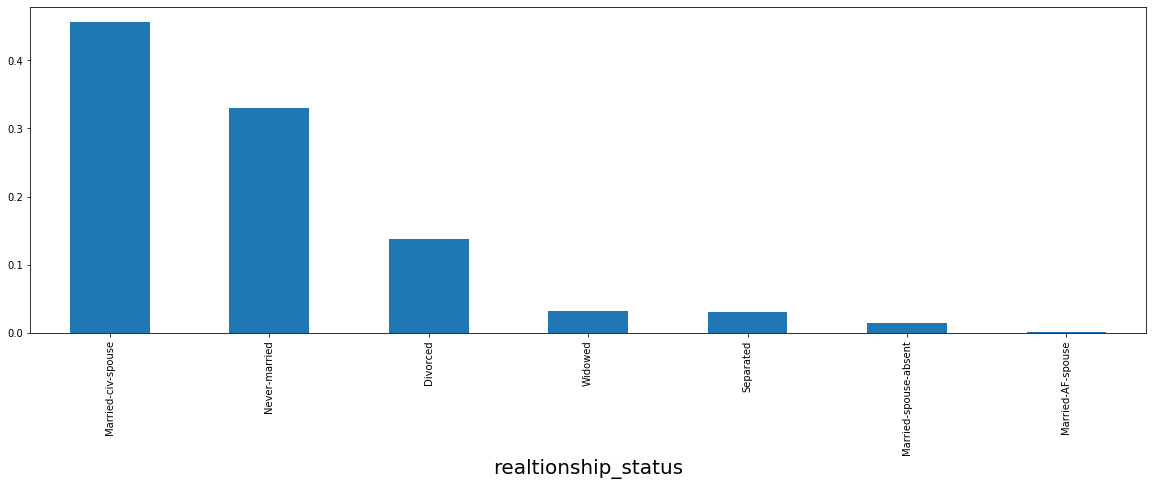

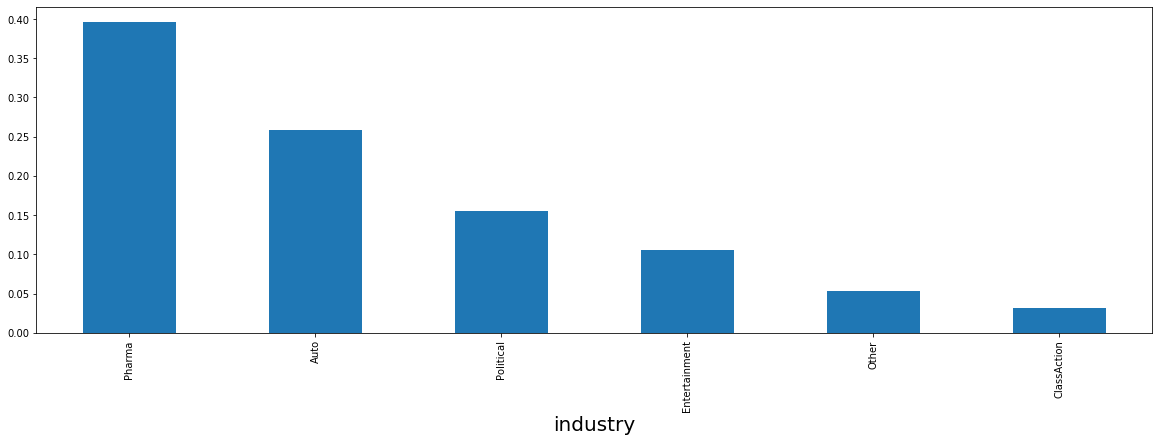

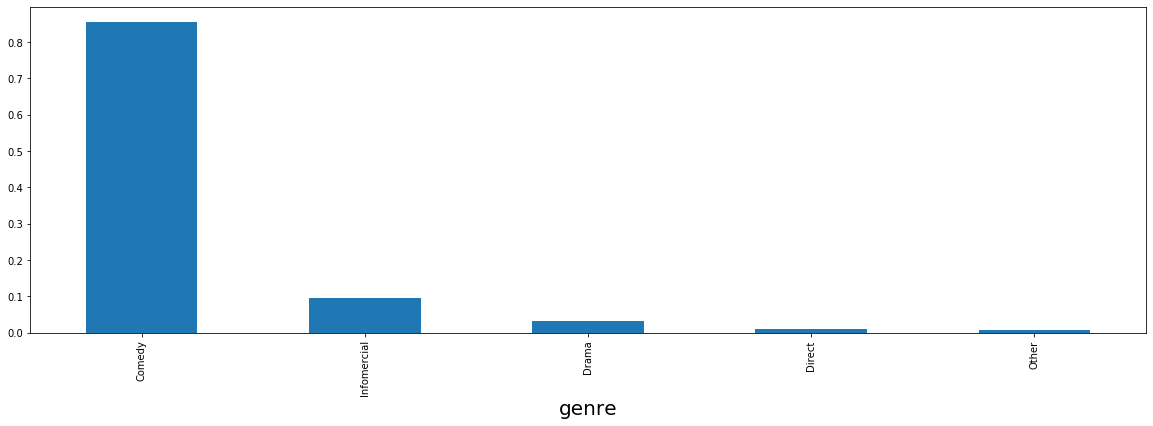

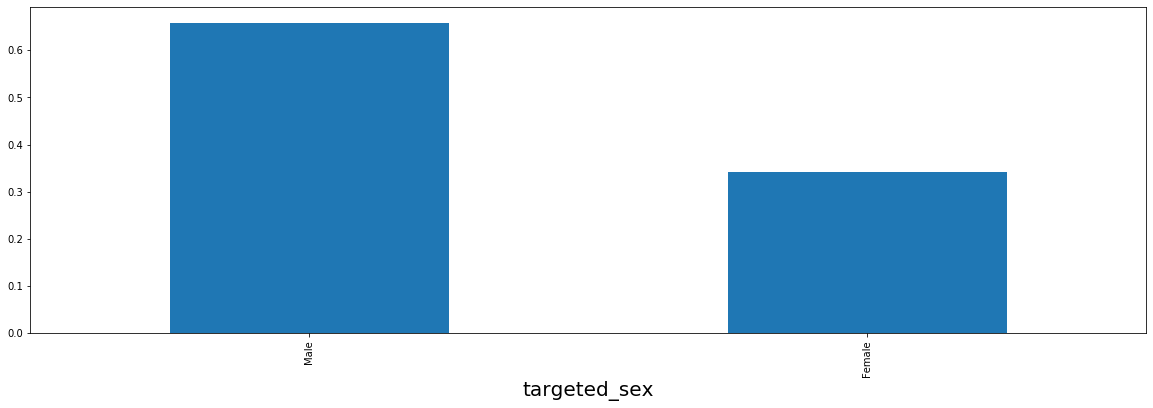

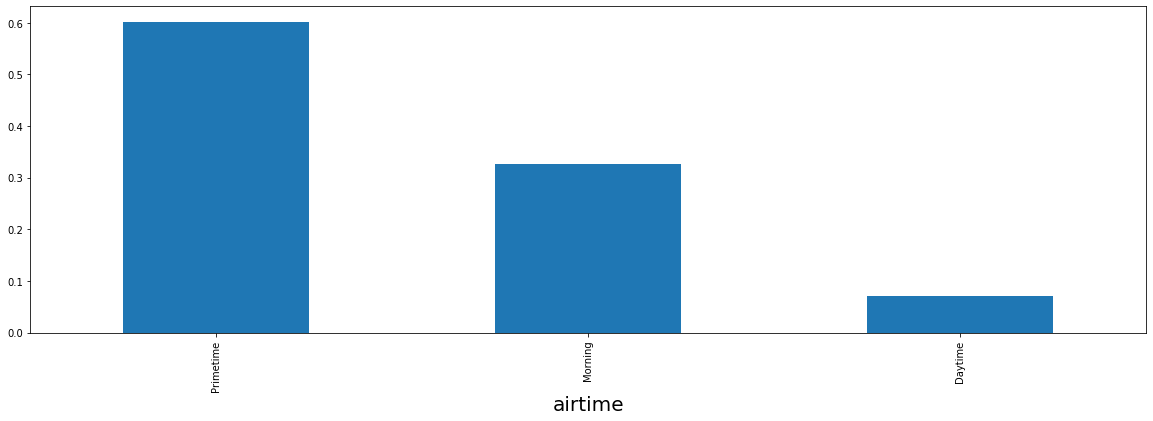

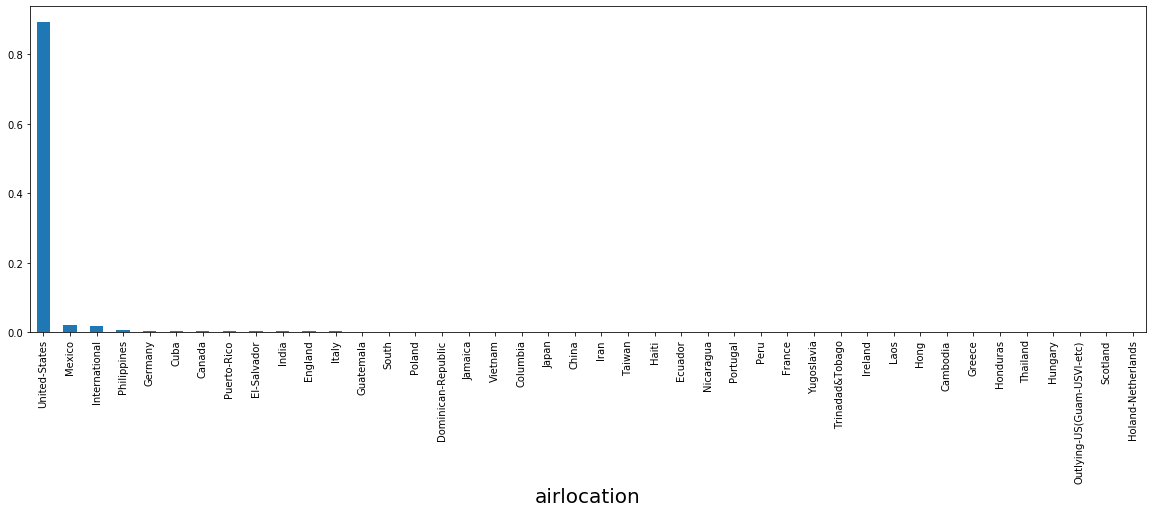

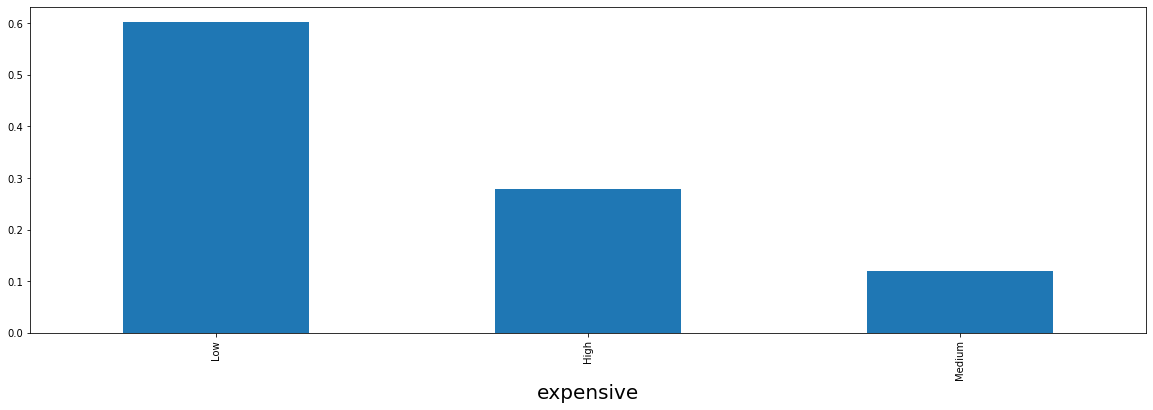

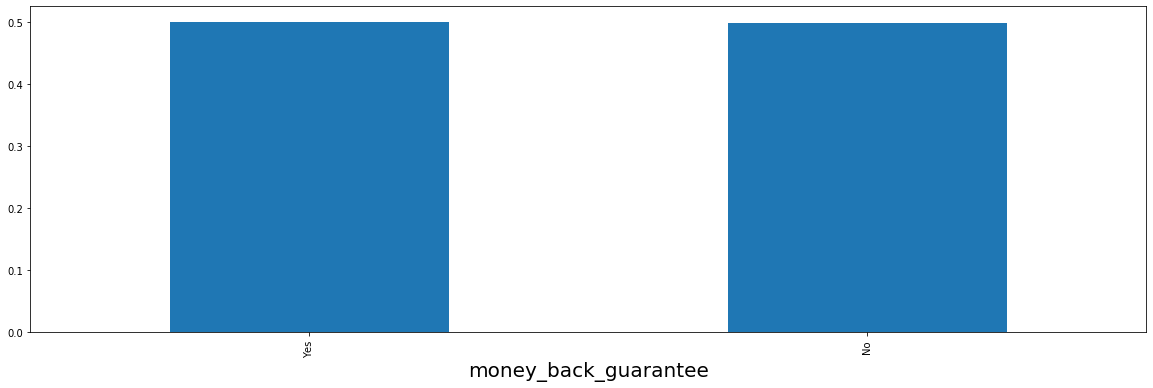

In [604]:
# Univariate analysis on Categorical data
def plot_categorical_columns(df):
    categorical_data = categorical(df)
    categorical_data = categorical_data.drop('UserID')
    df = df[categorical_data]
    for i in df:
        plt.figure(figsize=(20,6))
        plt.xlabel(i,fontsize=20)
        df[i].value_counts(normalize=True).plot(kind='bar')
        plt.show()
plot_categorical_columns(X)

-> 50% of the data comprises of the users married to a civilian spouse and the next major relationship status is being never married
-> Most of the users, almost 40% of the users belong to Pharma industry and automobile, political, entertainment industries being 50% of the data
-> 90% of the advertisement genres is comedy and the other genres being informercial, Drama, Direct in the 10% of the data
-> The maximum targeted sex is male i.e. 70%, Female being only 30%
-> 60% of the advertisements are being aired during the prime time, 30% during morning and only 10% during the day time.
-> Almost 90% of the data comprises of United states airlocation
-> Almost 60% of the ads are less expensive, 30% being highly expensive and 10% being medium expensive
-> Half of the ads are having money back guarantee and the other half of them dont.

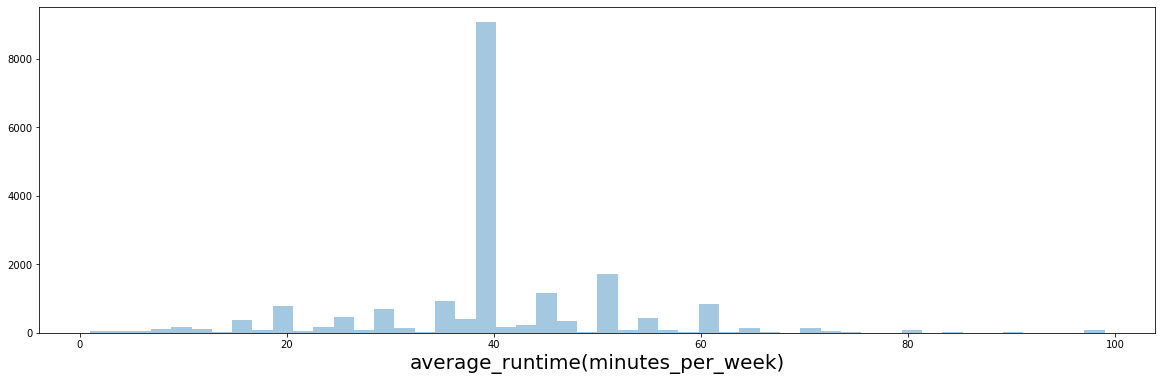

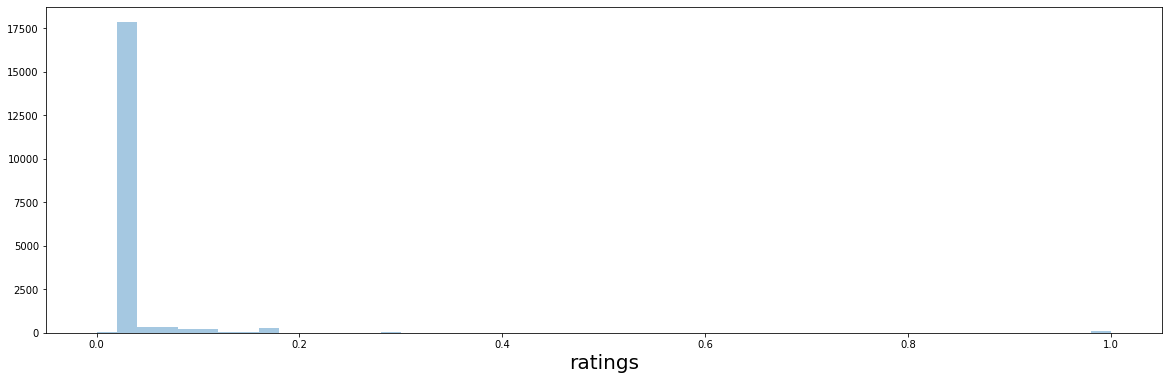

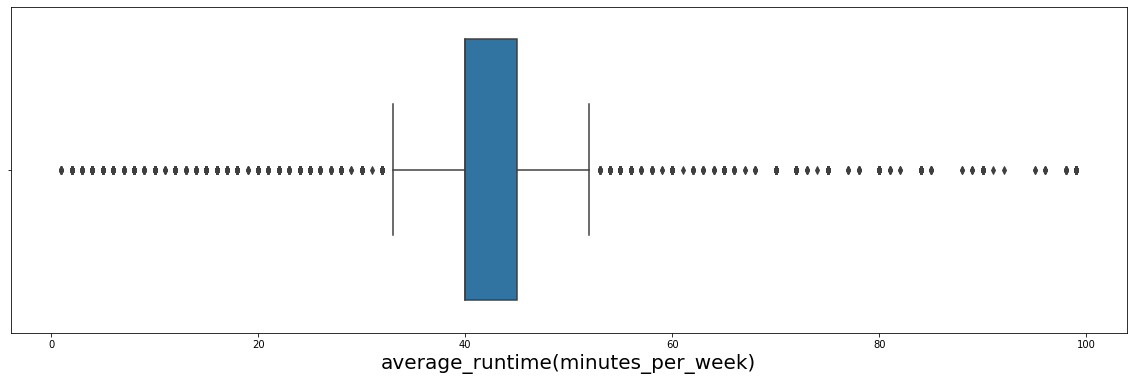

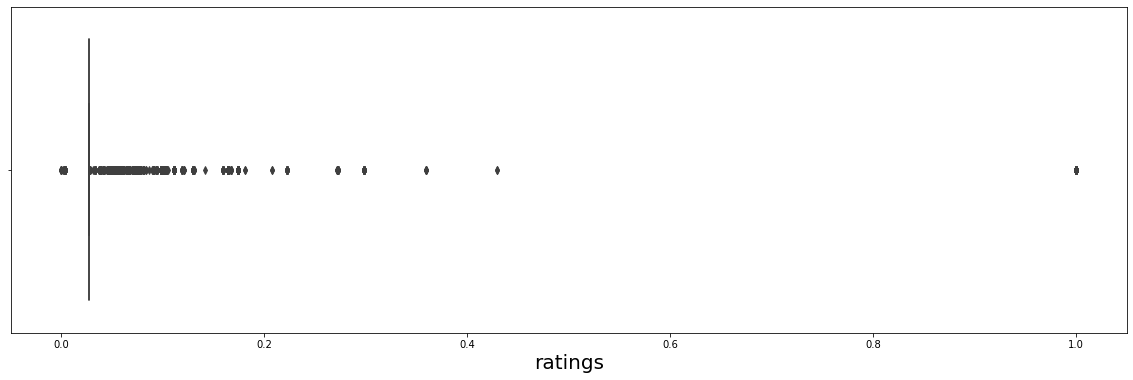

In [605]:
# Univariate Analysis on continuous columns
# Plot Histograms
def plot_continuous_columns(df):
    numeric_cols = numeric(df)
    df = df[numeric_cols]
    for i in range(0,len(numeric_cols)):
        plt.figure(figsize = (20,6))
        sns.distplot(df[numeric_cols[i]],kde=False)
        plt.xlabel(numeric_cols[i],fontsize=20)
        plt.show()
#Plot BoxPlots
def plot_box_plots(df):
    numeric_cols = numeric(df)
    df = df[numeric_cols]
    for i in range(0,len(numeric_cols)):
        plt.figure(figsize = (20,6))
        sns.boxplot(df[numeric_cols[i]])
        plt.xlabel(numeric_cols[i],fontsize=20)
        plt.show()
plot_continuous_columns(X)
plot_box_plots(X)

In [606]:
# Detect outliers in continuous columns
def detect_outliers(df):
    cols = list(df)
    for col in cols:
        if col in numeric(df):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - 1.5*iqr
            fence_high = q3 +1.5*iqr
            print(col + ' -- ', "Outliers count: ", df.loc[(df[col] < fence_low) | (df[col] > fence_high)].shape[0],"fence low : ",fence_low,"fence high : ",fence_high)
detect_outliers(X)

average_runtime(minutes_per_week) --  Outliers count:  5422 fence low :  32.5 fence high :  52.5
ratings --  Outliers count:  1736 fence low :  0.027464672 fence high :  0.027464672


# Function to treat outliers
def treat_outliers(df):
    cols = list(df)
    for col in cols:
        if col in numeric(df):
            df[col] = winsorize(df[col], limits=[0.05, 0.1],inclusive=(True, True))
    return df    
X = treat_outliers(X)
print(detect_outliers(X))

<Figure size 720x432 with 0 Axes>

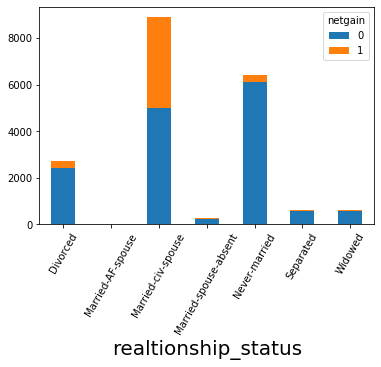

<Figure size 720x432 with 0 Axes>

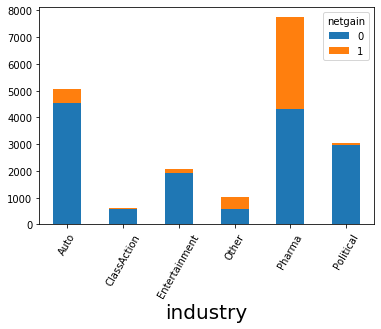

<Figure size 720x432 with 0 Axes>

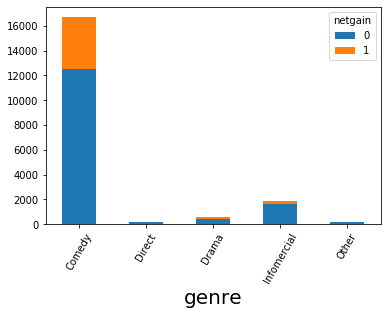

<Figure size 720x432 with 0 Axes>

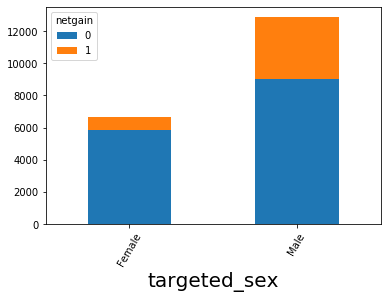

<Figure size 720x432 with 0 Axes>

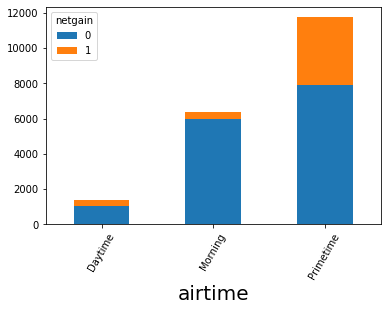

<Figure size 720x432 with 0 Axes>

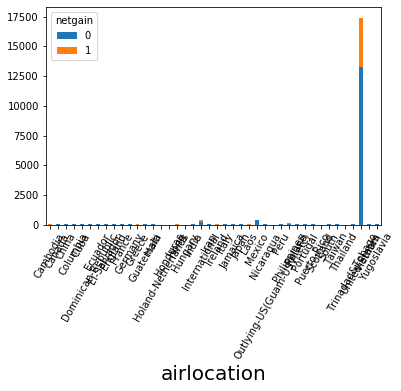

<Figure size 720x432 with 0 Axes>

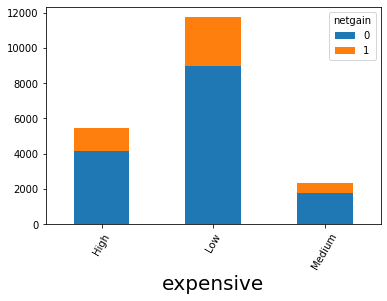

<Figure size 720x432 with 0 Axes>

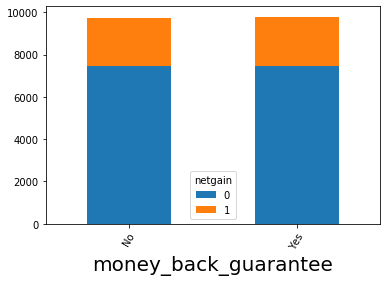

In [607]:
# Bivariate Analysis on categorical columns
data_df = X.copy()
data_df['netgain'] = y.values
def bivariate_analysis_categorical(df):
    cols = categorical(df)
    cols = cols.drop('UserID')
    for col in cols:
        plt.figure(figsize= (10,6))
        df_cross = pd.crosstab(df[col],df['netgain'])
        df_cross.plot(kind='bar',stacked=True)
        plt.xlabel(col,fontsize=20)
        plt.xticks(rotation=60)
        plt.show()
bivariate_analysis_categorical(data_df)

-> Netgain is more when the relationship status is married with a civilian spouse and least when the relationship status is among married spouse absent and married in armed forces spouse
-> Netgain is maximum in the Pharma industry and least in ClassAction industry

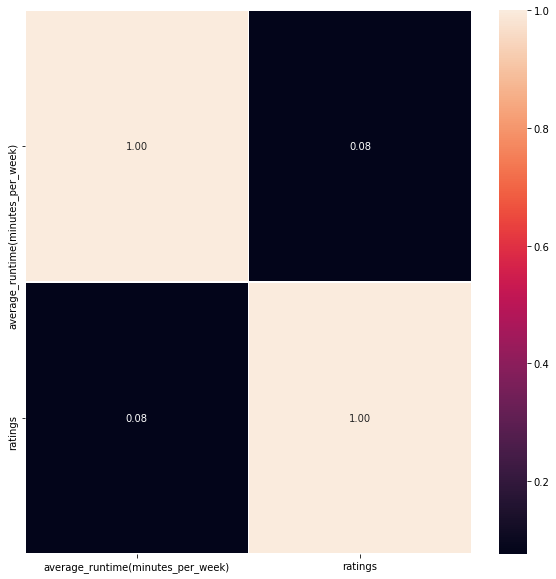

In [608]:
# Correlation heatmap of the data
data_corr = X[numeric(X)].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data_corr,annot=True,fmt=".2f",linewidths=.5,ax=ax)

In [609]:
#X = X[X['airlocation']=='United-States']
#X.drop(['airlocation'],1,inplace = True)
#X.drop(['UserID'],1,inplace=True)
#X = X[(X['average_runtime(minutes_per_week)']>32.5) & (X['average_runtime(minutes_per_week)']<52.5)]
X['UserID'] = X['UserID'].str.split('_',expand=True)[1]
y = y.iloc[X.index]
print(X.head())

  UserID realtionship_status   industry        genre targeted_sex  \
0   9185  Married-civ-spouse     Pharma       Comedy         Male   
1    449       Never-married  Political       Comedy         Male   
2   9014       Never-married       Auto       Comedy         Male   
3  14987  Married-civ-spouse     Pharma  Infomercial         Male   
4  25532  Married-civ-spouse      Other       Comedy       Female   

   average_runtime(minutes_per_week)    airtime    airlocation   ratings  \
0                                 40    Daytime  United-States  0.027465   
1                                 35    Morning  International  0.027465   
2                                 40    Morning  United-States  0.027465   
3                                 40  Primetime  United-States  0.027465   
4                                 50  Primetime  United-States  0.027465   

  expensive money_back_guarantee  
0    Medium                   No  
1       Low                   No  
2       Low            

In [612]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2, random_state = 2)
# Encoding the Categorical Columns
cat_df = X_train.select_dtypes(include=['object']).drop(['UserID'],1)
#label Encoding
le = LabelEncoder()
for col in cat_df.columns:
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
scaler = StandardScaler()
#normalizer = MinMaxScaler()
scaler.fit(X_train[['average_runtime(minutes_per_week)']])
X_train[['average_runtime(minutes_per_week)']] = scaler.transform(X_train[['average_runtime(minutes_per_week)']])
X_val[['average_runtime(minutes_per_week)']] = scaler.transform(X_val[['average_runtime(minutes_per_week)']])

In [613]:
def run_model(xtrain, xval, ytrain, yval, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    model.fit(xtrain, ytrain)
    y_scores = model.predict(xval)
    auc = roc_auc_score(yval, y_scores)
    print("Accuracy train Score : ",model.score(xtrain,ytrain))
    print("Accuracy val Score : ",model.score(xval,yval))
    print(classification_report(y_val,y_scores))
    print(confusion_matrix(y_val,y_scores))
    return auc

models = [LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier]
for model in models:
    # run model
    model = model()
    auc = run_model(X_train, X_val, y_train, y_val, model) # train and returns AUC test score
    print('AUC Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(model))
    print('===='*20)

Accuracy train Score :  0.7573585871512669
Accuracy val Score :  0.7574206755373593
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      2970
           1       0.48      0.11      0.18       938

    accuracy                           0.76      3908
   macro avg       0.63      0.54      0.52      3908
weighted avg       0.70      0.76      0.70      3908

[[2853  117]
 [ 831  107]]
AUC Score = 53.73 %
On Model - 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy train Score :  1.0
Accuracy val Score :  0.7505117707267144
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2970
           1       0.48    

GradientBoosting - 66.28%
RF - 63.96%
DecisionTree - 62.23%
logistic - 50.7%

In [614]:
tl = TomekLinks(random_state=0)
X_sample4, y_sample4 = tl.fit_sample(X_train,y_train)
model_tl = RandomForestClassifier(random_state=0)
model_tl.fit(X_sample4,y_sample4)
y_pred = model_tl.predict(X_val)
accuracy_tl = model_tl.score(X_val,y_val)
print("Accuracy : ",accuracy_tl)
recall_tl = recall_score(y_val,y_pred)
print("Recall Score : ",recall_tl)
precision_tl = precision_score(y_val,y_pred)
print("Precision Score : ",precision_tl)
f1_tl = f1_score(y_val,y_pred)
print("F1 score : ",f1_tl)
confusion_mat_tl = confusion_matrix(y_val,y_pred)
print("Confusion Matrix : ",confusion_mat_tl)
auc = roc_auc_score(y_val, y_pred)
print("AUC score : ",auc*100)

Accuracy :  0.7929887410440123
Recall Score :  0.5330490405117271
Precision Score :  0.574052812858783
F1 score :  0.552791597567717
Confusion Matrix :  [[2599  371]
 [ 438  500]]
AUC score :  70.4066607797951


In [615]:
parameter_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 5],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
clf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=clf,param_grid=parameter_grid)
grid_search.fit(X_train,y_train)
f1_grid = f1_score(y_val,y_pred_rus)
print("F1 score : ",f1_grid)

F1 score :  0.6206896551724137


In [616]:
rus = RandomUnderSampler(random_state=0)
X_sample2,y_sample2 = rus.fit_sample(X_train,y_train)
model_rus = GradientBoostingClassifier(random_state=0)
model_rus.fit(X_sample2,y_sample2)
y_pred_rus = model_rus.predict(X_val)
accuracy_rus = model_rus.score(X_val,y_val)
print("Accuracy : ",accuracy_rus)
recall_rus = recall_score(y_val,y_pred_rus)
print("Recall Score : ",recall_rus)
precision_rus = precision_score(y_val,y_pred_rus)
print("Precision Score : ",precision_rus)
f1_rus = f1_score(y_val,y_pred_rus)
print("F1 score : ",f1_rus)
confusion_mat_rus = confusion_matrix(y_val,y_pred_rus)
print("Confusion Matrix : ",confusion_mat_rus)
auc_rus = roc_auc_score(y_val, y_pred_rus)
print("AUC score : ",auc_rus*100)

Accuracy :  0.7479529170931423
Recall Score :  0.8646055437100213
Precision Score :  0.4859197124026363
F1 score :  0.6221710778672804
Confusion Matrix :  [[2112  858]
 [ 127  811]]
AUC score :  78.78583274105662


f1 score - 0.58
AUC score - 73.3

In [617]:
smote = SMOTE(random_state=0)
X_sample6, y_sample6 = smote.fit_sample(X_train,y_train)
model_smote = GaussianNB()
model_smote.fit(X_sample6,y_sample6)
y_pred = model_smote.predict(X_val)
accuracy_smote = model_smote.score(X_val,y_val)
print("Accuracy Score : ",accuracy_smote)
recall_smote = recall_score(y_val,y_pred)
print("Recall Score : ",recall_smote)
precision_smote = precision_score(y_val,y_pred)
print("Precision Score : ",precision_smote)
f1_smote = f1_score(y_val,y_pred)
print("F1 Score : ", f1_smote)
auc = roc_auc_score(y_val, y_pred)
print("AUC score : ",auc)
confusion_mat_smote = confusion_matrix(y_val,y_pred)
print("Confusion Matrix : ", confusion_mat_smote)

Accuracy Score :  0.7177584442169908
Recall Score :  0.7633262260127932
Precision Score :  0.4483406386975579
F1 Score :  0.5648915187376726
AUC score :  0.7333466146898983
Confusion Matrix :  [[2089  881]
 [ 222  716]]


In [618]:
test_data = pd.read_csv(r'C:\Users\bhasy\Downloads\Emp_Assessment\test.csv')
#test_data = test_data[test_data['airlocation']=='United-States']
#test_data.drop(['airlocation'],1,inplace = True)
#X = X[(X['average_runtime(minutes_per_week)']>32.5) & (X['average_runtime(minutes_per_week)']<52.5)]
test_data['UserID'] = test_data['UserID'].str.split('_',expand=True)[1]
print(test_data.head())

  UserID realtionship_status       industry        genre targeted_sex  \
0   8772       Never-married  Entertainment  Infomercial       Female   
1  13139            Divorced           Auto       Comedy       Female   
2  15381  Married-civ-spouse         Pharma  Infomercial         Male   
3  15503       Never-married           Auto       Comedy         Male   
4  16556       Never-married      Political       Comedy         Male   

   average_runtime(minutes_per_week)    airtime    airlocation   ratings  \
0                                 40  Primetime  United-States  0.027465   
1                                 40  Primetime  United-States  0.027465   
2                                 40  Primetime  United-States  0.027465   
3                                 30  Primetime  United-States  0.027465   
4                                 70    Morning  United-States  0.027465   

  expensive money_back_guarantee  
0      High                  Yes  
1       Low                   No  

In [619]:
cat_df = test_data.select_dtypes(include=['object']).drop(['UserID'],1)
#label Encoding
for col in cat_df.columns:
    test_data[col] = le.fit_transform(test_data[col])
#Scaling the data
test_data[['average_runtime(minutes_per_week)']] = scaler.transform(test_data[['average_runtime(minutes_per_week)']])
y_test_pred = model_rus.predict(test_data)
final_df = pd.DataFrame(data={'netgain': y_test_pred})
final_df.set_index('netgain',inplace=True)
final_df.to_csv(r'C:\Users\bhasy\Downloads\Emp_Assessment\predictions_rus.csv')